# Point matching for automatic fiducial registration

This is an important problem for doing thick PALM where we take data in slabs but each slab has to be individually drift corrected. We have an overall scaffold to which we need to align the data.

Ideally we'd generate a program that would do the following steps
1. Read in the data (or generate it ...)
    1. Read in slab data
    2. Read in scaffold data
2. Automatically find fiducials
    1. Do drift correction if it hasn't been done already
    2. localize fiducials in the scaffold
3. **Using the fiducials automatically align the slabs to the scaffold.**

The last point is the issue for this notebook. We'll be primarily working off the methods mentioned [here](https://en.wikipedia.org/wiki/Point_set_registration).

The main methods are:
1. [Iterative closest point](https://en.wikipedia.org/wiki/Iterative_closest_point)
    - http://connor-johnson.com/2014/06/06/an-iterative-closest-point-algorithm/
    - https://stackoverflow.com/questions/20120384/iterative-closest-point-icp-implementation-on-python
    - https://engineering.purdue.edu/kak/distICP/ICP-2.0.html
    - https://github.com/ClayFlannigan/icp
2. Robust point matching
    - http://scikit-image.org/docs/dev/auto_examples/transform/plot_matching.html
3. Kernel Correlation
4. Coherent Point Drift
    - https://github.com/Hennrik/Coherent-Point-Drift-Python
    - https://github.com/siavashk/pycpd

![](https://upload.wikimedia.org/wikipedia/commons/f/fe/Cpd_fish_affine.gif)

# Basics

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.transform
from pycpd import affine_registration, deformable_registration, rigid_registration
from mpl_toolkits.mplot3d import Axes3D

%load_ext autoreload
%autoreload 2
import pyPALM.registration as myreg

# Testing out the `pycpd` package

https://github.com/siavashk/pycpd (no idea if this is implemented correctly)

http://siavashk.github.io/2017/05/14/coherent-point-drift/ blog post explaining the math

Original paper: https://arxiv.org/pdf/0905.2635.pdf

**Note:** if the code follows the notation of the paper then $w$ is the weight of the uniform distribution that's included in the gaussian mixture model to model noise. We need to test a good default value for this parameter but 0.5 seems good from initial experiments (2D)

One thing they mention in the paper:
>We shall always prealign both point sets to zero mean and unit variance before the registration.

## Starting out with the fishy

In [2]:
# need to add translation only registration
class translation_registration(object):
    def __init__(self, X, Y, t=None, sigma2=None, maxIterations=100, tolerance=0.001, w=0):
        if X.shape[1] != Y.shape[1]:
            raise 'Both point clouds must have the same number of dimensions!'

        self.X             = X
        self.Y             = Y
        self.TY            = Y
        (self.N, self.D)   = self.X.shape
        (self.M, _)        = self.Y.shape
        self.t             = np.atleast_2d(np.zeros((1, self.D))) if t is None else t
        self.sigma2        = sigma2
        self.iteration     = 0
        self.maxIterations = maxIterations
        self.tolerance     = tolerance
        self.w             = w
        self.q             = 0
        self.err           = 0

    def register(self, callback):
        self.initialize()

        while self.iteration < self.maxIterations and self.err > self.tolerance:
            self.iterate()
            if callback:
                callback(iteration=self.iteration, error=self.err, X=self.X, Y=self.TY)

        return self.TY, np.atleast_2d(self.t), self.P

    def iterate(self):
        self.EStep()
        self.MStep()
        self.iteration += 1

    def MStep(self):
        self.updateTransform()
        self.transformPointCloud()
        self.updateVariance()

    def updateTransform(self):
        muX = np.divide(np.sum(np.dot(self.P, self.X), axis=0), self.Np)
        muY = np.divide(np.sum(np.dot(np.transpose(self.P), self.Y), axis=0), self.Np)

        self.XX = self.X - np.tile(muX, (self.N, 1))
        YY      = self.Y - np.tile(muY, (self.M, 1))

        self.A = np.dot(np.transpose(self.XX), np.transpose(self.P))
        self.A = np.dot(self.A, YY)

        self.YPY = np.dot(np.transpose(self.P1), np.sum(np.multiply(YY, YY), axis=1))

        self.t = np.transpose(muX) - np.transpose(muY)

    def transformPointCloud(self, Y=None):
        if Y is None:
            self.TY = self.Y + np.tile(np.transpose(self.t), (self.M, 1))
            return
        else:
            return Y + np.tile(np.transpose(self.t), (Y.shape[0], 1))

    def updateVariance(self):
        # needs work
        qprev = self.q

        trAR     = np.trace(self.A)
        xPx      = np.dot(np.transpose(self.Pt1), np.sum(np.multiply(self.XX, self.XX), axis =1))
        self.q   = (xPx - 2 * trAR + self.YPY) / (2 * self.sigma2) + self.D * self.Np/2 * np.log(self.sigma2)
        self.err = np.abs(self.q - qprev)

        self.sigma2 = (xPx - trAR) / (self.Np * self.D)

        if self.sigma2 <= 0:
            self.sigma2 = self.sigma_init = self.sigma_init * 2.0
            self.t = -self.Y.mean(axis=0) + self.X.mean(axis=0)
            #+np.random.randn(*self.t.shape) * np.sqrt(self.Y.var(axis=0) * self.sigma2 + self.X.mean(axis=0))
            #self.t = np.zeros_like(self.t)
            self.transformPointCloud()
    
    def initialize(self):
        self.TY = self.Y + np.repeat(self.t, self.M, axis=0)
        if not self.sigma2:
            XX = np.reshape(self.X, (1, self.N, self.D))
            YY = np.reshape(self.TY, (self.M, 1, self.D))
            XX = np.tile(XX, (self.M, 1, 1))
            YY = np.tile(YY, (1, self.N, 1))
            diff = XX - YY
            err  = np.multiply(diff, diff)
            self.sigma2 = np.sum(err) / (self.D * self.M * self.N)
            
        self.sigma_init = self.sigma2

        self.err  = self.tolerance + 1
        self.q    = -self.err - self.N * self.D/2 * np.log(self.sigma2)

    def EStep(self):
        P = np.zeros((self.M, self.N))

        for i in range(0, self.M):
            diff     = self.X - np.tile(self.TY[i, :], (self.N, 1))
            diff    = np.multiply(diff, diff)
            P[i, :] = P[i, :] + np.sum(diff, axis=1)

        c = (2 * np.pi * self.sigma2) ** (self.D / 2)
        c = c * self.w / (1 - self.w)
        c = c * self.M / self.N
        
        P = np.exp((-P / (2 * self.sigma2)))
        den = np.sum(P, axis=0)
        den = np.tile(den, (self.M, 1))
        den = np.maximum(np.finfo(float).eps, den)
        den += c

        self.P   = np.divide(P, den)
        self.Pt1 = np.sum(self.P, axis=0)
        self.P1  = np.sum(self.P, axis=1)
        self.Np  = max(np.finfo(float).eps, np.sum(self.P1))

In [3]:
def plot_results(X, Y, TY):
    
    if X.shape[-1] == 3:
        projection = "3d"
    else:
        projection = None
    fig = plt.figure(figsize=(4,8))
    ax0 = fig.add_subplot(211, projection=projection)
    ax1 = fig.add_subplot(212, projection=projection)
    
    ax0.scatter(*X.T, color='red')
    ax0.scatter(*Y.T, color='blue', marker="x")
    
    ax1.scatter(*X.T, color='red')
    ax1.scatter(*TY.T, color='blue', marker="x")
    ax0.set_aspect('equal', 'datalim')
    ax1.set_aspect('equal', 'datalim')

## Testing on a toy model for fiducials

In [4]:
import seaborn as sns
sns.set()

In [5]:
def rmse(p1, p2):
    return np.sqrt(((p1 - p2)**2).sum(1)).mean()

In [6]:
scale = 1
trans = np.random.rand(1, 2) * 1

ps1 = np.random.rand(50, 2) * scale
ps2 = ps1 + trans * scale

In [7]:
kwargs1 = dict(t=None, sigma2=None, maxIterations=1000, tolerance=1e-6, w=0)
kwargs2 = dict(tol=1e-6, maxiters=1000, weight=0, init_var=None, translation=None)
reg1 = translation_registration(ps1, ps2, **kwargs1)
reg2 = myreg.TranslationCPD(ps1, ps2)

with np.errstate(invalid="raise"):
    %time result1 = reg1.register(None)
    %time result2 = reg2(**kwargs2)
    print(reg1.iteration)
    print(reg2.iteration)

#     plot_results(ps1, ps2, result1[0])
#     plot_results(ps1, ps2, result2[0])

CPU times: user 12.9 ms, sys: 1.43 ms, total: 14.3 ms
Wall time: 13.2 ms
CPU times: user 3.19 ms, sys: 1.11 ms, total: 4.3 ms
Wall time: 3.41 ms
12
8


12 3.26651386307e-16 0.0
8 3.26651386307e-16 232.232022088


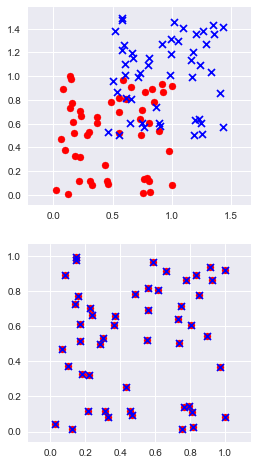

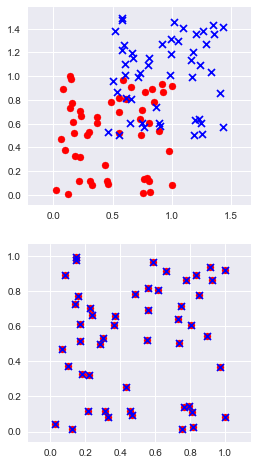

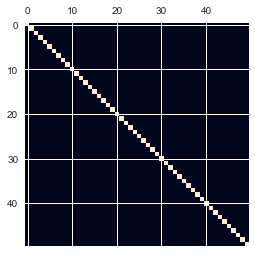

In [8]:
print(reg1.iteration, rmse(ps1, result1[0]), reg1.err)
print(reg2.iteration, rmse(ps1, result2), reg2.Q_old - reg2.Q)
plot_results(ps1, ps2, result1[0])
plot_results(ps1, ps2, result2)
plt.matshow(reg2.p_old)

# Extra points

In [9]:
trans = np.random.rand(1, 2) * 1

realpnts = np.random.rand(50, 2)
ps1 = np.concatenate((realpnts, np.random.rand(np.random.randint(20), 2)), axis=0)
ps2 = np.concatenate((realpnts, np.random.rand(np.random.randint(20), 2)), axis=0) + trans
print(ps1.shape, ps2.shape)

(63, 2) (50, 2)


472
7 8.72773189575e-13


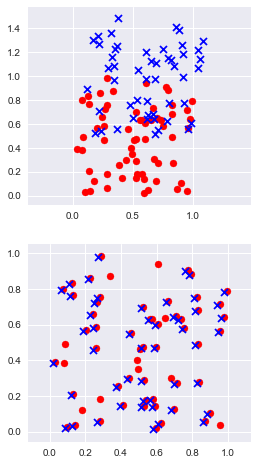

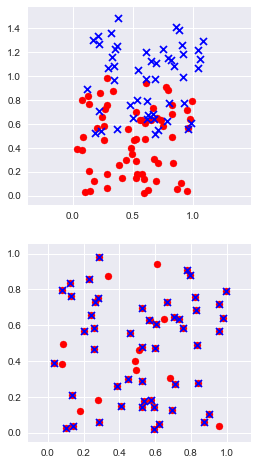

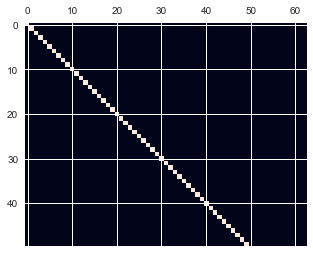

In [10]:
kwargs1 = dict(t=None, sigma2=None, maxIterations=1000, tolerance=1e-6, w=0.2)
kwargs2 = dict(tol=1e-6, maxiters=1000, weight=0.2, init_var=None)
reg1 = translation_registration(ps1, ps2, **kwargs1)
reg2 = myreg.TranslationCPD(ps1, ps2)

with np.errstate(invalid="raise"):
    result1 = reg1.register(None)
    result2 = reg2(**kwargs2)
    print(reg1.iteration)
    print(reg2.iteration, reg2.rmse)

    plot_results(ps1, ps2, result1[0])
    plot_results(ps1, ps2, result2)
plt.matshow(reg2.p_old)

## Jiggled points

In [11]:
trans = np.random.rand(1, 2) * 1

realpnts = np.random.rand(50, 2)
ps1 = realpnts + np.random.randn(*realpnts.shape)*0.02
ps2 = realpnts + np.random.randn(*realpnts.shape)*0.02 + trans

23
17 0.000762884159421


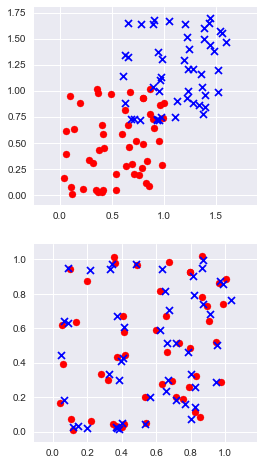

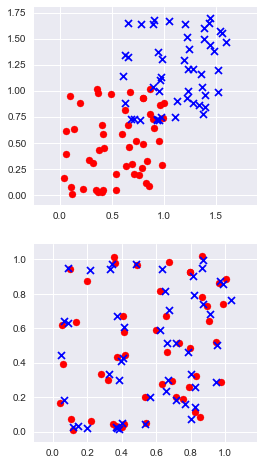

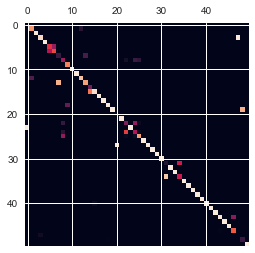

In [12]:
kwargs1 = dict(t=None, sigma2=None, maxIterations=1000, tolerance=1e-6, w=0.)
kwargs2 = dict(tol=1e-6, maxiters=1000, weight=0., init_var=None)
reg1 = translation_registration(ps1, ps2, **kwargs1)
reg2 = myreg.TranslationCPD(ps1, ps2)

with np.errstate(invalid="raise"):
    result1 = reg1.register(None)
    result2 = reg2(**kwargs2)
    print(reg1.iteration)
    print(reg2.iteration, reg2.rmse)

    plot_results(ps1, ps2, result1[0])
    plot_results(ps1, ps2, result2)
plt.matshow(reg2.p_old)